In [155]:
from __future__ import annotations
from pathlib import Path
import json
from contextlib import contextmanager
import contextlib
import io
from copy import deepcopy
from torch.utils.hooks import RemovableHandle
from jinja2 import Template
import pydantic
import os
import tqdm
import matplotlib.pyplot as plt
import time
import math
from datasets import concatenate_datasets
from collections import defaultdict
import gc
from safetensors.torch import save_file as safetensors_save_file
from safetensors.torch import load_file as safetensors_load_file
import random
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM
import numpy as np
# import zipnn # TODO(Adriano) start using ZNN to save activations for better performance on storage: https://github.com/zipnn/zipnn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dotenv
from jaxtyping import Float, Int
import einops
from typing import List, Dict, Any, Optional, Union, Tuple, Callable

In [96]:
"""
0243AC20-4B14-4405-934E-57248BB464E7

Cleaner implementation of probing for length using a template dataset.
We already observed that the LLM is able to perform the task of generating longer vs. shorter prompts.

Main things to look for:
1. Is it significantly better than random AND also significantly better predicting based on the length of the prompt?
2. Which layers are we able to probe at best?
3. Ensure that the size of the dataset is LARGER than the latent dimensionality we are operating at.

Output:
- Per-layer diagram of probe performance where we have a "-1st layer" layer representing linear predictor from input length
    and a "0th" layer representing the length prediction based on the embeddings.
- For the best layers, a correlation between the predicted and true lengths + R^2.

Information on the file structure:

File Structure for generate_prompt_variations_dataset
- `default_length_options.json`: JSON file containing the default length options (list of integers).
- `default_topics.json`: JSON file containing the default topics (list of strings).
- `default_template.jinja`: Jinja template for the default prompt template (template with keys `topic` and `length` where you insert 
    those from the above files).

Know, but ignore this:
- `default_variation_template.jinja`: note used but basically was meant to be used to generate variations on prompts using an LLM
    (i.e. synthetic data to make our analysis more robust).
"""
#### CREATE THE DATASET ####
# TODO(Adrianoh) we should create a better system for this, i.e. using hierarchical templating:
#   1. Prompt 1 might be something like "write me {{count}} sub-topics about {{high level topic}}" (i.e. write me 10 topics about AI)
#   2. etc...
# For this initial thing I did it manually :/
class FilledTemplate(pydantic.BaseModel):
    length: str # Should be string since we will be putting this into a prompt, just stringifying the int
    topic: str
    prompt: str

def render_template(length_options: Path | List[int], topic_options: Path | List[str], template: Path | Template) -> List[str]:
    if isinstance(length_options, Path):
        length_options = json.loads(length_options.read_text())
        length_options = list(set(length_options)) # Make sure there are no duplicates
    if isinstance(topic_options, Path):
        topic_options = json.loads(topic_options.read_text())
        topic_options = list(set(topic_options)) # Make sure there are no duplicates
    if isinstance(template, Path):
        template = Template(template.read_text())
    return [
        FilledTemplate(
            length=str(length),
            topic=topic,
            prompt=template.render(length=length, topic=topic)
        ) for length in length_options for topic in topic_options
    ]

print("Rendering template prompts for (probe) regression on length...")
templated_prompts = render_template(
    # NOTE: we do NOT use default but instead binary which is short/long so that we can easily experiment w/
    # steering from shorter to longer (later on, we will try to experiment with some number of sent. to another number
    # of sent.)
    length_options=Path.cwd() / "generate_prompt_variations_dataset" / "binary_length_options.json",
    topic_options=Path.cwd() / "generate_prompt_variations_dataset" / "default_topics.json",
    template=Path.cwd() / "generate_prompt_variations_dataset" / "binary_template.jinja"
)
random.seed(42)
random.shuffle(templated_prompts)
datasets: Dict[str, Dataset] = {
    "default_template": Dataset.from_list(
        [value.model_dump() for value in templated_prompts],
        features=Features(
            length=Value(dtype="string"),
            topic=Value(dtype="string"),
            prompt=Value(dtype="string")
        )
    )
}
print(f"Templates rendered (total number of templates: {len(templated_prompts)}), here are some examples (first from list, then dataset):")
print('\t- "' + '"\n\t- "'.join(x.model_dump_json() for x in templated_prompts[:10]) + '"')
print("\n\n")
print("Dataset:")
print(datasets["default_template"])
# Apparently dict of string to list?
print(datasets["default_template"][:1])
# Obviously, list of strings
print(datasets["default_template"]["prompt"][:1])
# Dict with string: string
print(datasets["default_template"][0])
# Two strings:
print(datasets["default_template"]["prompt"][0])
print(datasets["default_template"][0]["prompt"])
print("="*100)

Rendering template prompts for (probe) regression on length...
Templates rendered (total number of templates: 4268), here are some examples (first from list, then dataset):
	- "{"length":"really long","topic":"Ryan Gosling","prompt":"In at most a coherent paragraph or two, please write me a really long essay about Ryan Gosling."}"
	- "{"length":"really short","topic":"agricultural subsidies in the US","prompt":"In at most a coherent paragraph or two, please write me a really short essay about agricultural subsidies in the US."}"
	- "{"length":"really short","topic":"eclipses","prompt":"In at most a coherent paragraph or two, please write me a really short essay about eclipses."}"
	- "{"length":"really short","topic":"importance of market segmentation","prompt":"In at most a coherent paragraph or two, please write me a really short essay about importance of market segmentation."}"
	- "{"length":"really long","topic":"Dielectric Materials","prompt":"In at most a coherent paragraph or two

In [2]:
#### CREATE THE MODEL ####
"""
A4501E1A-2460-45D9-BC47-D60E060B7F53

Create model(s) for our experiments and make sure they fit on memory, etc...
"""
print("Initializing model, tokenizer and device...")
assert os.environ["CUDA_VISIBLE_DEVICES"] != "", "CUDA_VISIBLE_DEVICES is not set"
model_name = "meta-llama/Llama-3.2-1B-Instruct" # Small model to begin with
device = "cuda"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
# tokenizer.padding_side = "left" # I thought this was the right way to generate, but it makes the model suck; we use right side and it manages to .generate() and look OK somehow
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
# print(model) # DEBUG
model_hidden_size = model.model.embed_tokens.weight.data.shape[1]
print(f"Model hidden dimensionality={model_hidden_size}, remember; dataset_size={len(templated_prompts)}; (ideally you have higher dimensionality PER class, i.e. topic)") # num_tokens x hidden_size
assert model_hidden_size < len(templated_prompts), "Model hidden dimensionality is smaller than the number of templates..."
print("="*100)

Initializing model, tokenizer and device...
Model hidden dimensionality=2048, remember; dataset_size=4268; (ideally you have higher dimensionality PER class, i.e. topic)


In [97]:
#### TOKENIZE THE DATASET (have it ready to feed into the model) ####
"""
1169AD0D-385B-425B-9914-693FE975E51F

Generates a dataset that we can USE for our experiments.
"""
system_prompt = """You are a helpful and informative assistant that can answer questions about the world. Try
to cause no harm and aim primarily to give information to users who may be curious about different facts."""
class EncodingArgs(pydantic.BaseModel):
    test_size_pct: float = 0.2
    llm_tok_max_length: int = 4096
    llm_tok_max_prompt_length: Optional[int] = None
    system_prompt: Optional[str] = system_prompt
    message_key: Optional[str | Dict[str, str]] = "prompt"

class DatasetEncoder:
    """
    A static-like (but stateful) class to coordinate the creation of a TON of tokenized and standardized
    dataset objects that we can use to basically do batched inference. This should make it really easy to
    run inference on huggingface datasets with various LLMs.

    The main way to do this is to:
    1. Init
    2. Call `get_trainable_datasets` to get something that you can train/run inference on.
    """
    def __init__(
            self,
            model: AutoModelForCausalLM,
            tokenizer: AutoTokenizer,
            datasets: Dict[str, Dataset],
            device: Optional[str]=None,
            encoding_args: EncodingArgs=EncodingArgs()
        ) -> None:
        """models, datasets are { model/dataset_name: model/dataset }"""
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.raw_datasets: Dict[str, Dataset] = datasets
        self.train_test_raw_datasets: Dict[str, Tuple[Dataset, Dataset]] = {}
        self.train_test_convo_datasets: Dict[str, Tuple[Dataset, Dataset]] = {}
        self.train_test_tok_datasets: Dict[str, Tuple[Dataset, Dataset]] = {}
        self.encoding_args = encoding_args

        # Create some variables to make this faster to query
        self.llm_tok_max_length = self.encoding_args.llm_tok_max_length
        self.llm_tok_max_prompt_length = self.encoding_args.llm_tok_max_prompt_length if self.encoding_args.llm_tok_max_prompt_length is not None else self.llm_tok_max_length // 4 # fmt: skip
        self.test_size_pct = self.encoding_args.test_size_pct
        # Create a default dictionary for the message key (note this is meant to tell you the message key per dataset;
        # it's not perfect since you might have multiple messages you want to format, but we'll handle that in a future
        # version)
        self.default_message = self.encoding_args.message_key if isinstance(self.encoding_args.message_key, str) else self.encoding_args.message_key.get("default", None) # fmt: skip
        self.message_key_dict = {} if (self.encoding_args.message_key is None or isinstance(self.encoding_args.message_key, str)) else self.encoding_args.message_key # fmt: skip
        self.message_key_dict = defaultdict(lambda: self.default_message, self.message_key_dict) # fmt: skip
        # ....
        self.system_prompt = self.encoding_args.system_prompt

        # Used instead of allowing user template, since Llama sort of forces there to be a date string
        # and if it changes every time we run this, it will be more non-deterministic and that could
        # be problematic for our results
        self.date_string: str = "23 Jan 2025" 

        # Does more logging/printign, etc...
        self.debug_mode: bool = True

    def get_train_test_raw_datasets(self) -> None:
        """split train/test and filter out prompts that are too long"""
        for dataset_name, dataset in self.raw_datasets.items():
            message_key = self.message_key_dict[dataset_name]
            assert message_key is not None, f"message_key_dict={self.message_key_dict}, dataset_name={dataset_name}"
            assert dataset is not None
            dataset = dataset.shuffle(seed=42)
            dataset = dataset.filter(lambda x: len(x[message_key]) <= self.llm_tok_max_length)
            assert dataset is not None
            dataset = dataset.filter(lambda x: len(x[message_key]) <= self.llm_tok_max_prompt_length)
            assert dataset is not None
            test_size = int(len(dataset) * self.test_size_pct)
            train_size = len(dataset) - test_size
            assert test_size > 0 and train_size > 0
            train_dataset = dataset.select(range(train_size))
            test_dataset = dataset.select(range(train_size, len(dataset)))
            assert len(train_dataset) + len(test_dataset) == len(dataset)
            assert len(train_dataset) == train_size
            assert len(test_dataset) == test_size
            self.train_test_raw_datasets[dataset_name] = (train_dataset, test_dataset)
    
    def format_convo(self, x: dict, response_key: Optional[str]=None, dataset_name: Optional[str]=None) -> dict:  # fmt: skip
        message_key = self.message_key_dict[dataset_name] if dataset_name is not None else self.default_message # fmt: skip
        if response_key is not None:
            raise NotImplementedError("We do not use responses yet... because we want native model generations")
        convo = {'conversation': []}
        if self.system_prompt is not None:
            convo['conversation'].append({'role': 'system', 'content': self.system_prompt})
        if message_key is not None:
            convo['conversation'].append({'role': 'user', 'content': x[message_key]})
        x.update(convo)
        return x
    
    def tok_and_tmpl(self, x: dict, max_length: Optional[int] = None) -> dict: # fmt: skip
        shared_kwargs = {"date_string": self.date_string, "truncation": False } # for unk. reasons adding gen. prompt is bad; fmt: skip
        # NOTE: for unknown reasons, left padding SUCKS and default is right padding, so we just use right padding LOL
        if max_length is not None:
            shared_kwargs["max_length"] = max_length
            shared_kwargs["padding"] = "max_length"
        x.update({
            # https://huggingface.co/docs/transformers/v4.35.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.apply_chat_template.add_generation_prompt; fmt: skip
            # NOTE: we do not transition to device becasue it doesn't actually do it
            'input_ids': self.tokenizer.apply_chat_template(x["conversation"], tokenize=True, return_tensors="pt", **shared_kwargs), # fmt: skip
            'input_templated': self.tokenizer.apply_chat_template(x["conversation"], tokenize=False, **shared_kwargs), # fmt: skip
        })
        return x
    
    def get_trainable_datasets(self) -> Dict[str, Tuple[Dataset, Dataset]]:
        """
        This is basically the main method for this function. NOTE that the output will be in a specific format:
        - Dataset object of dict-like objects
        - Each dict-like object has the following keys:
            - 'input_ids': a tensor of token ids (what you put into your model)
            - 'input_templated': a string of the templated input (so you can sanity check the tokenization)
            - 'conversation': a list of dicts with keys 'role' and 'content' (OpenAI API-like format)
            - ... possibly whatever else was there before
        """
        # 1. Get raw datasets
        if self.debug_mode:
            print("Getting train/test raw datasets...")
        self.get_train_test_raw_datasets()
        assert len(self.train_test_raw_datasets) == len(self.raw_datasets)
        
        # 2. Format (or more technically just like a step to do step 3 ngl.)
        if self.debug_mode:
            print("Formatting datasets to be in conversation format...")
        pbar = self.train_test_raw_datasets.items()
        if self.debug_mode:
            pbar = tqdm.tqdm(pbar, total=len(self.train_test_raw_datasets), desc="Formatting datasets to be in conversation format") # fmt: skip
        for dataset_name, (train_raw, test_raw) in pbar:
            self.train_test_convo_datasets[dataset_name] = (train_raw.map(self.format_convo), test_raw.map(self.format_convo)) # fmt: skip
        assert len(self.train_test_convo_datasets) == len(self.train_test_raw_datasets)
        
        # 3. Tokenize
        if self.debug_mode:
            print("Applying chat template and tokenizing datasets...")
            pbar = self.train_test_convo_datasets.items()
            if self.debug_mode:
                pbar = tqdm.tqdm(pbar, total=len(self.train_test_convo_datasets), desc="Applying chat template and tokenizing datasets...") # fmt: skip
            # 3.1. Conversion
            for dataset_name, (train_convo, test_convo) in pbar:
                # 3.1.1. Tokenize to get max_length
                _train_tok, _test_tok = train_convo.map(self.tok_and_tmpl), test_convo.map(self.tok_and_tmpl) # fmt: skip
                # 3.1.2. Sanity check lengths and get those lengths
                lengths_train = np.array([len(x['input_ids'][0]) for x in _train_tok])
                lengths_test = np.array([len(x['input_ids'][0]) for x in _test_tok])
                assert np.max(lengths_train).item() <= self.encoding_args.llm_tok_max_length
                assert np.max(lengths_test).item() <= self.encoding_args.llm_tok_max_length
                if self.debug_mode:
                    max_length_train, min_length_train = np.max(lengths_train).item(), np.min(lengths_train).item()
                    max_length_test, min_length_test = np.max(lengths_test).item(), np.min(lengths_test).item()
                    print(f"max length train: {max_length_train}, min length train: {min_length_train}") # DEBUG
                    print(f"max length test: {max_length_test}, min length test: {min_length_test}") # DEBUG
                # 3.1.3. Create with padding (turns out for Llama model this is right padding, but in general what
                #   matters is that we can generate and that we get OK/good looking responses relative to the capabilities
                #   of the model)
                train_tok = _train_tok.map(lambda x: self.tok_and_tmpl(x, max_length=max_length_train))
                test_tok = _test_tok.map(lambda x: self.tok_and_tmpl(x, max_length=max_length_test))
                self.train_test_tok_datasets[dataset_name] = (train_tok, test_tok) # fmt: skip
            # 3.2 Sanity check
            assert len(self.train_test_tok_datasets) == len(self.train_test_convo_datasets)
        return self.train_test_tok_datasets

In [98]:
"""
18DC19ED-89DE-4BB3-A29C-EB20EBFF9B86
Use the library functions we just defined
"""
print("Encoding dataset(s) into tokenized format for inference...")
encoding_args = EncodingArgs(
    message_key="prompt",
    test_size_pct=0.005 # 4200 or so, so this should be around 15 or so samples :)
    # Defaults are fine, look above
)
dataset_encoder_decoder = DatasetEncoder(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets,
    device=device,
    encoding_args=encoding_args
)
datasets = dataset_encoder_decoder.get_trainable_datasets()
dataset_train, dataset_test = datasets["default_template"]
for _dataset_name, _dataset in zip(["train", "test"], [dataset_train, dataset_test]):
    print(f"After tokenization the dataset_{_dataset_name} looks like this:")
    print(_dataset) # This should show you the real size
    print(_dataset[:1])
    print("="*100)

Encoding dataset(s) into tokenized format for inference...
Getting train/test raw datasets...


/mnt/align3_drive/adrianoh/miniconda3/envs/ifyoudont/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.EncodingArgs'>.
  StockPickler.save(self, obj, save_persistent_id)
/mnt/align3_drive/adrianoh/miniconda3/envs/ifyoudont/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.EncodingArgs'>: __main__.EncodingArgs has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Filter:   0%|          | 0/4268 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4268 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format...


Formatting datasets to be in conversation format:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/4247 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format: 100%|██████████| 1/1 [00:19<00:00, 19.27s/it]


Applying chat template and tokenizing datasets...


Applying chat template and tokenizing datasets...:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/4247 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

max length train: 105, min length train: 87
max length test: 95, min length test: 87


Map:   0%|          | 0/4247 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Applying chat template and tokenizing datasets...: 100%|██████████| 1/1 [00:44<00:00, 44.21s/it]

After tokenization the dataset_train looks like this:
Dataset({
    features: ['length', 'topic', 'prompt', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 4247
})
{'length': ['really short'], 'topic': ['why chores are always unfair'], 'prompt': ['In at most a coherent paragraph or two, please write me a really short essay about why chores are always unfair.'], 'conversation': [[{'content': 'You are a helpful and informative assistant that can answer questions about the world. Try\nto cause no harm and aim primarily to give information to users who may be curious about different facts.', 'role': 'system'}, {'content': 'In at most a coherent paragraph or two, please write me a really short essay about why chores are always unfair.', 'role': 'user'}]], 'input_ids': [[[128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696, 25, 6790, 220, 2366, 18, 198, 15724, 2696, 25, 220, 1419, 4448, 220, 2366, 20, 271, 2675, 527, 264, 11190, 323, 39319, 18328, 430, 649, 4320, 4860,

In [ ]:
"""
04547389-B235-4446-ABD6-12DC80FB0E51

Utility functions to basically enable easy steering later down the line.
"""
class NamedForwardHooks:
    def __init__(self, model: nn.Module):
        self.model = model
        self.hooks: Dict[str, RemovableHandle] = {}

    def add_hook(self, name: str, hook_fn: Callable, pre: bool = False):
        # Tries to add it to a MODULE: should work ok?
        named_modules = dict(self.model.named_modules())
        if name not in named_modules:
            raise ValueError(
                f"No module named '{name}' found in the model: {list(n for n, _ in self.model.named_modules())}."
            )

        module = named_modules[name]
        handle = (
            (
                module.register_forward_hook(
                    lambda mod, inp, out: hook_fn(self, name, mod, inp, out)
                )
            )
            if not pre
            else (
                module.register_forward_pre_hook(
                    # NOTE: we pass "None" to signify that this was meant to be a pre-hook
                    lambda mod, inp: hook_fn(self, name, mod, inp, None)
                )
            )
        )
        self.hooks[name] = handle

    def remove_hooks(self):
        for hook in self.hooks.values():
            hook.remove()
        self.hooks.clear()

@contextmanager
def named_forward_hooks(
    model: nn.Module, hook_dict: Dict[str, Callable | tuple[Callable, bool]]
):
    hooks = NamedForwardHooks(model)

    for name, hook_fn_obj in hook_dict.items():
        hook_fn = hook_fn_obj if isinstance(hook_fn_obj, Callable) else hook_fn_obj[0]
        pre = hook_fn_obj[1] if isinstance(hook_fn_obj, tuple) else False
        hooks.add_hook(name, hook_fn, pre=pre)

    try:
        yield hooks
    finally:
        hooks.remove_hooks()


def steering_vec2steering_module(steering_vec: torch.Tensor, device: Optional[torch.device | str]=None) -> torch.nn.Module: # fmt: skip
    """Convert a steering vector to a module that just adds in the vector AKA identity + bias."""
    device = device if device is not None else torch.device("cpu")
    model_hidden_size: int = steering_vec.shape[0]
    linear_module = torch.nn.Linear(model_hidden_size, model_hidden_size)
    linear_module.weight.data = torch.eye(model_hidden_size)
    linear_module.bias.data = steering_vec.clone()
    linear_module.to(device)
    return linear_module

def test_steering_vec2steering_module(device: Optional[torch.device | str]=None):
    """
    A test to make sure that our function ``steering_vec2steering_module`` works as expected :)

    It SHOULD BE IMMEDIATELY CALLED BELOW.
    """
    random_bias = torch.randn(1024, device="cpu") # On cpu for testing purposes
    testing_steering_module = steering_vec2steering_module(random_bias, device=device)
    random_batch_X = torch.randn(100, 1024, device=device) # On actual device
    random_batch_expected_y = random_batch_X + random_bias.to(device)
    random_batch_y = testing_steering_module(random_batch_X)
    assert torch.allclose(random_batch_y, random_batch_expected_y)
    del random_batch_X, random_batch_expected_y, random_batch_y, testing_steering_module
    gc.collect()
    torch.cuda.empty_cache()
print("[Test] steering_vec2steering_module")
test_steering_vec2steering_module(device=device)
print("[OK] Test passed for steering_vec2steering_module")

def filter_hook_fn(
    filter_module: nn.Module,
    hooks_object: NamedForwardHooks,
    name: str,
    module: nn.Module,
    input: torch.Tensor | tuple[torch.Tensor, ...],
    output: Optional[torch.Tensor | tuple[torch.Tensor, ...]],
):
    """
    A PyTorch hook function that intercepts + modify the residual stream hook_fn. Use any nn_module as
    a filter (if you will) since it means we can reuse across steering, linear modifications, etc...

    Meant for usage in a llama model or similar.
    """
    assert output is None
    assert isinstance(input, tuple)
    assert isinstance(input[0], torch.Tensor)
    assert sum(isinstance(i, torch.Tensor) for i in input) == 1
    new_input = filter_module(input[0])
    return tuple([new_input] + list(input[1:]))

def test_filter_hook_fn(model: LlamaForCausalLM, tokenizer: AutoTokenizer) -> str:
    """
    A test to make sure that our function `filter_hook_fn` works as expected :)
    
    It SHOULD BE IMMEDIATELY CALLED BELOW and then you should see that the output that gets printed SUCKS
    (i.e. because we added a ton of noise).
    """
    print("Creating hook module...")
    assert isinstance(model, LlamaForCausalLM)
    hidden_size = model.model.embed_tokens.weight.shape[1]
    hook_noise = torch.randn(hidden_size, device=model.device) * 100.0
    hook_module = steering_vec2steering_module(hook_noise, model.device)

    print("Creating test dataset...")
    test_dataset = Dataset.from_list(
        [
            {"text": "What is the capital of France?"} for _ in range(10)
        ], 
        features=Features(
            {
                "text": Value(dtype="string")
            }
        )
    )
    print("Creating dataset... still...")
    dataset_encoder = DatasetEncoder(
        model=model,
        tokenizer=tokenizer,
        datasets={"test": test_dataset},
        device=model.device,
        encoding_args=EncodingArgs(batch_size=5, max_length=100, message_key="text")
    ) # fmt: skip
    print("Creating dataset... still (cmon bro)...")
    datsets_tok = dataset_encoder.get_trainable_datasets()
    print(datsets_tok["test"])  # DEBUG; fmt: skip
    print("Lengths and types:") # DEBUG; fmt: skip
    print(" - " + "\n - ".join(f"len={len(_)}, type={type(_)}, len elem0={len(_[0])}, type elem0={type(_[0])}, type elem00={type(_[0][0])}" for _ in datsets_tok["test"][0]["input_ids"])) # DEBUG; fmt: skip
    pt_tok = torch.cat([torch.Tensor(_).long() for _ in datsets_tok["test"][0]["input_ids"]]).to(model.device)
    assert len(pt_tok.shape) == 2 # batch x seq
    assert pt_tok.shape[0] >= 0 and pt_tok.shape[0]== len(datsets_tok["test"][0])
    print("Generating...")
    output: str = "\n\nWITH HOOK:\n\n"
    with named_forward_hooks(model, {
        "model.layers.5": ( # Just kind of an arbitrary layer for testing
            lambda hooks_object, name, module, inp, out: filter_hook_fn(hook_module, hooks_object, name, module, inp, out),
            # Pre-hook: before module takes it in (otherwise it is after)...
            # NOTE: that pre-hook is the right way to do it if we want to optimize AFAIK
            True
        )
    }):
        generated_pt = model.generate(inputs=pt_tok).detach().to("cpu")
        generated_str = tokenizer.batch_decode(generated_pt, skip_special_tokens=True)
        output += "\n--------\n".join(generated_str) + "\n\n"
    # Add something without the hook for good measure (you should compare and see that this looks reasonable, but the alternative above does not)
    output += "\n\nWITH NO HOOK:\n\n"
    generated_pt = model.generate(inputs=pt_tok).detach().to("cpu")
    generated_str = tokenizer.batch_decode(generated_pt, skip_special_tokens=True)
    output += "\n--------\n".join(generated_str) + "\n\n"
    return output
print(model)
print("="*100)
print("[Test] test_filter_hook_fn")
print(test_filter_hook_fn(model=model, tokenizer=tokenizer)) # Test that output looks like what we expect
print("[CHECK OUTPUT] Test done for test_filter_hook_fn")

[Test] steering_vec2steering_module
[OK] Test passed for steering_vec2steering_module
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        

Filter:   0%|          | 0/10 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format...


Formatting datasets to be in conversation format:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format: 100%|██████████| 1/1 [00:22<00:00, 22.80s/it]


Applying chat template and tokenizing datasets...


Applying chat template and tokenizing datasets...:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

max length train: 75, min length train: 75
max length test: 75, min length test: 75


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Applying chat template and tokenizing datasets...: 100%|██████████| 1/1 [00:43<00:00, 43.17s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


(Dataset({
    features: ['text', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 8
}), Dataset({
    features: ['text', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 2
}))
Lengths and types:
 - len=1, type=<class 'list'>, len elem0=75, type elem0=<class 'list'>, type elem00=<class 'int'>
 - len=1, type=<class 'list'>, len elem0=75, type elem0=<class 'list'>, type elem00=<class 'int'>
 - len=1, type=<class 'list'>, len elem0=75, type elem0=<class 'list'>, type elem00=<class 'int'>
 - len=1, type=<class 'list'>, len elem0=75, type elem0=<class 'list'>, type elem00=<class 'int'>
 - len=1, type=<class 'list'>, len elem0=75, type elem0=<class 'list'>, type elem00=<class 'int'>
 - len=1, type=<class 'list'>, len elem0=75, type elem0=<class 'list'>, type elem00=<class 'int'>
 - len=1, type=<class 'list'>, len elem0=75, type elem0=<class 'list'>, type elem00=<class 'int'>
 - len=1, type=<class 'list'>, len elem0=75, type elem0=<class 'list'>, type elem00=<class

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




WITH HOOK:

system

Cutting Knowledge Date: December 2023
Today Date: 23 Jan 2025

You are a helpful and informative assistant that can answer questions about the world. Try
to cause no harm and aim primarily to give information to users who may be curious about different facts.user

What is the capital of France?冬 Pactached冬");

 else Gewereoodelistüz Pact])] tổn tổn tổn.stream Else").zug tổn
--------
system

Cutting Knowledge Date: December 2023
Today Date: 23 Jan 2025

You are a helpful and informative assistant that can answer questions about the world. Try
to cause no harm and aim primarily to give information to users who may be curious about different facts.user

What is the capital of France? Else Pact Gewaldiodelistereo tổnached else.Defaultaldi.stream.streamолькоodelist tổn])] hindsightereo");


--------
system

Cutting Knowledge Date: December 2023
Today Date: 23 Jan 2025

You are a helpful and informative assistant that can answer questions about the world. Try
to cause n

In [139]:

#### CREATING ACTIVATIONS TO PERFORM THE LEARNING EXPERIMENTS ####
"""
FD331D0F-DA7E-4088-A442-AE1C429E5E99

Just provide utilities to create a bunch of activations and generations from a dataset. This is meant
to sort of generalize the behavior we want from above.

TODO(Adriano) refactor into this stuff because it's cleaner and will be more reusable, less bug-prone, etc...
"""
assert os.environ["OUTPUT_DIR"] != "", "OUTPUT_DIR is not set"

class DecodingArgs(pydantic.BaseModel):
    """
    Args for the decoder.
    """
    # Turns out on my machine 511 is really good and 513 is really bad (probably some cache thing)
    batch_size: int | Tuple[int, int] = 511
    generation_kwargs: Dict[str, Any] = {
        # NOTE: we keep these as a dict to feed them into the **kwargs for a huggingface (generate) function
        "do_sample": True,
        "temperature": 1,
        "top_k": 50,
        "top_p": 0.95,
        # This may seem dumb, but basically, we actually don't do generation itself, per-say,
        # all the time, i.e. we only want to get the activations from the model
        "max_new_tokens": 1
    }

class BatchEncodedOutput(pydantic.BaseModel):
    """
    A class to store the output of a batch of encoded outputs.
    """
    model_config = pydantic.ConfigDict(arbitrary_types_allowed=True)
    generations: List[str] # Includes the generations :P
    batch_size_optimized: Optional[int] = None
    input_ids_pt: Optional[torch.Tensor] = None
    activations: Optional[Dict[str, torch.Tensor]] = None

class DatasetDecoder:
    """
    A static-like (but also stateful, like above) class that lets you:
    1. Run a generation loop
        - Normally
        - With hooks (and the ability to apply the hook on a single token or multiple SPECIFIC tokens in
            the generation of the .generate() call)
    2. Decode the generations in strings so we can print them.
    3. Get the activations from the model
        and store them on disk efficiently-ish....
    """

    def __init__(
            self,
            model: AutoModelForCausalLM,
            tokenizer: AutoTokenizer,
            device: Optional[str]=None,
            decoding_args: Optional[DecodingArgs]=None
    ) -> None:
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.decoding_args = decoding_args
    def batch_decode(
        self,
        model: AutoModelForCausalLM,
        tokenizer: AutoTokenizer,
        questions: Dataset | torch.Tensor,
        # TODO(Adrianoh) transition to the pydantic schema :P
        # NOTE: that after some optimization 511 was found to be good for performance, and
        # we suspect it might have something to do with some kind of cache size
        batch_size: int | Tuple[int, int] = 511,
        generation_kwargs: Dict[str, Any] = {
            "do_sample": True,
            "temperature": 1,
            "top_k": 50,
            "top_p": 0.95,
            # Notice how these default settings mean that we roughly are in line with the amount of allowable
            # generation as defined before
            "max_new_tokens": 1 #1024
        },
        device='cuda:0',
        optimize_batch_size: bool = False,
        return_input_ids_pt: bool = False,
        return_optimal_batch_size: bool = False,
        return_activations: bool = False, # TODO(Adrianoh) modify to make it easier to store the activations in a sort of "streaming" way i.e. don't OOM lol
        debug: bool = False,
    ) -> BatchEncodedOutput:
        """
        Run a bunch of inference and get the input+output+activations (if you so wish).
        Returns:
            - The input dataset in the tensor form for reuse if requested
            - The input dataset in the tokenized form for display purposes
            - The activations from the model if requested
        """
        batch_size_lower, generations, activations = None, None, None
        try:
            if isinstance(questions, Dataset):
                all_input_ids = []
                for input_ids in tqdm.tqdm(questions['input_ids'], total=len(questions), desc="Converting input_ids to tensor (and moving to device)"):
                    assert len(input_ids) == 1
                    all_input_ids.append(input_ids[0])
                questions = torch.Tensor(all_input_ids).long().to(device) # transition all to device in one big chunk
            else:
                assert isinstance(questions, torch.Tensor)
                questions = questions.to(device)
            if debug:      
                print("Shape of all_input_ids: {}".format(all_input_ids.shape))
                raise ValueError("optimize_batch_size is True but batch_size is an int, make sure it's a tuple range of batch sizes!")
            if optimize_batch_size:
                # TODO(Adrianoh) I will do this one day; it will speed up my workflow when I need to switch GPUs n shit
                raise NotImplementedError
            elif isinstance(batch_size, tuple):
                raise ValueError("optimize_batch_size is True but batch_size is an int, make sure it's a tuple range of batch sizes!")
            assert isinstance(batch_size, int)
            batch_size_lower = batch_size

            # ...
            generations: List[str] = []
            activations: List[torch.Tensor] = []
            times_per_batch: np.ndarray = np.zeros(math.ceil(len(questions) / batch_size_lower))
            for iter_i, i in enumerate(tqdm.trange(0, len(questions), batch_size_lower)):
                time_start = time.time()
                # Collect the batch
                left_idx, right_idx = i, min(i+batch_size, len(questions))
                toks_pt = questions[left_idx:right_idx]
                assert isinstance(toks_pt, torch.Tensor)
                assert toks_pt.shape[0] <= batch_size_lower
                assert toks_pt.device == model.device
                generation_tensor = model.generate(
                    input_ids=toks_pt,
                    **generation_kwargs
                )
                if return_activations:
                    # print('getting acts out yay') # debug
                    # TODO(Adrianoh) not only inputs plz wtf?
                    _acts_out = model(toks_pt, output_hidden_states=True) # only inputs yolooooo
                    _acts = _acts_out.hidden_states
                    # print("\n" + "\n".join(f"{x.shape}" for x in _acts))
                    shape0 = _acts[0].shape
                    assert all(x.shape == shape0 for x in _acts)
                    _stacked_acts = torch.stack(_acts, dim=0)
                    activations.append(_stacked_acts.detach().cpu()) # TODO(Adrianoh) optimize batched transfers to CPU so we run faster
                assert generation_tensor.shape[0] <= batch_size_lower # batch = 1
                assert len(generation_tensor.shape) == 2 # batch seq
                _gens = generation_tensor.to("cpu").detach()
                
                these_generations = tokenizer.batch_decode(_gens, skip_special_tokens=True)
                # for generation in generations:
                #     print(generation)
                #     print("="*100)
                generations.extend(these_generations)
                time_end = time.time()
                times_per_batch[iter_i] = time_end - time_start
                # This should be fast since it's a small number of averages
                if debug:
                    _running_avg = np.mean(times_per_batch[:iter_i+1])
                    _running_std = np.std(times_per_batch[:iter_i+1])
                    _running_max = np.max(times_per_batch[:iter_i+1])
                    _running_min = np.min(times_per_batch[:iter_i+1])
                    print(f"Secs per batch: {times_per_batch[iter_i]:.4f}; running avg={_running_avg:.4f}; std={_running_std:.4f}; max={_running_max:.4f}; min={_running_min:.4f}") # fmt: skip
            # print("="*100)
            # print("ACTIVATIONS SHAPES")
            # print("\n" + "\n".join(f"{x.shape}" for x in activations)) # Debug
            # print("="*100)
            assert all(len(act.shape) == 4 for act in activations)
            activations = torch.cat(activations, dim=1) if len(activations) > 0 else None # NOTE: this may not work because 
            hidden_dim_size = activations.shape[-1] if activations is not None else None
            assert questions is None or len(questions.shape) == 2
            max_input_length = questions.shape[1] if questions is not None else None # batch x seq
            expected_activations_shape = (len(model.model.layers)+1, len(generations), max_input_length, hidden_dim_size) if activations is not None else None # fmt: skip
            assert activations is None or (activations.shape == expected_activations_shape), f"Activations shape is {activations.shape} but expected {expected_activations_shape}"
        finally:
            try:
                del _acts_out, _acts
                gc.collect()
                torch.cuda.empty_cache()
            except NameError:
                pass
        assert batch_size_lower is not None and generations is not None, f"Your program probably failed :>"
        return BatchEncodedOutput(
            batch_size_optimized=batch_size_lower if return_optimal_batch_size else None,
            input_ids_pt=questions if return_input_ids_pt else None,
            generations=generations,
            activations=activations if return_activations else None
        )
    
    def create_activations_dataset(self, dataset: Dataset) -> Dataset:
        """
        Create a dataset of activations from the model.
        """
        raise NotImplementedError

    def create_generations_dataset(self, dataset: Dataset) -> Dataset:
        """
        Create a dataset of generations from the model.
        """
        raise NotImplementedError
    
    def generate_with_hooks(self, dataset: Dataset, hook_dict: Dict[str, Callable | tuple[Callable, bool]]) -> Dataset:
        """
        Generate generations from the model with hooks.
        # TODO(Adrianoh) implement the ability to just apply the hook on a single token generation of the .generate() call (I think the simplest way
        # TODO(Adrianoh) is just to call up until that token, then to call the model one, then to call generate on the remaining shit LOL)
        """
        raise NotImplementedError

# raise NotImplementedError

In [ ]:
"""
0283C0E0-DBE5-4E0D-B664-974E4677F3F0

Clean and simple implementation of two forms of steering:
- Probe-based steering
- Difference-of-means based steering

Main questions/things to look for:
1. Do we maintain coherence?
2. Do we retain topic/semantics?

NOTE: if you OOM then consider using a smaller batch size... even if it worked before,
it somehow resets some kind of internal state (something is not getting collected probably)
and then the big batch will work next time even if you shut this shit down manually.

First we start with difference-of-means steering here:
"""
try:
    del _hidden_states_full
    del hidden_states_full
    del long_dataset_pt
    del short_dataset_pt
    del input_full
    del is_eos_mask_full
    del hidden_states
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()

#### SPLIT REAL DATASET INTO LONG AND SHORT FOR DIFFERENCE OF MEANS STEERING ####
# This shit is TOKENIZED from a couple of blocks up: look for 1169AD0D-385...
long_dataset = dataset_train.filter(lambda x: x['length'] == 'really long')
short_dataset = dataset_train.filter(lambda x: x['length'] == 'really short')
assert len(long_dataset) + len(short_dataset) == len(dataset_train), f"len(long_dataset)={len(long_dataset)} + len(short_dataset)={len(short_dataset)} != len(dataset_train)={len(dataset_train)}" # fmt: skip
assert len(long_dataset) > model_hidden_size, f"len(long_dataset)={len(long_dataset)} <= model_hidden_size={model_hidden_size}" # fmt: skip
assert len(short_dataset) > model_hidden_size, f"len(short_dataset)={len(short_dataset)} <= model_hidden_size={model_hidden_size}" # fmt: skip

#### CREATE BATCH INPUT ####
print("Creating batch input...")
long_dataset_pt = torch.cat([torch.Tensor(_).long() for _ in long_dataset["input_ids"]])
short_dataset_pt = torch.cat([torch.Tensor(_).long() for _ in short_dataset["input_ids"]])
assert long_dataset_pt.shape[1] == short_dataset_pt.shape[1] # So we can cat :)
long_dataset_left, long_dataset_right = 0, len(long_dataset_pt)
short_dataset_left, short_dataset_right = len(long_dataset_pt), len(long_dataset_pt) + len(short_dataset_pt)
input_full = torch.cat([long_dataset_pt, short_dataset_pt], dim=0).to(model.device) # This is what we will do inference with
is_eos_mask_full = input_full == tokenizer.eos_token_id

#### GET ACTIVATIONS ####
print("Running inference (1 token)...")
batch_size = 20
times_per_batch: np.ndarray = np.zeros(math.ceil(len(input_full) / batch_size))
# This should take around 10-15m w/ batch size 10-20 and around 1-2m w/ batch size 50-100
# 1. Batched inference
_hidden_states_full: List[torch.Tensor] = []
move_hidden_states_to_cpu_every_n_batches = 1
for iter_i, i in enumerate(tqdm.trange(0, len(input_full), batch_size)):
    time_start = time.time()
    # 1. Batched inference
    input_batch = input_full[i:i+batch_size]
    outputs = model(input_batch, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    assert isinstance(hidden_states, tuple) and len(hidden_states) == len(model.model.layers) + 1 # +1 for the embeddings
    # 2. Store hidden states + move hidden states to CPU every n batches
    _hidden_states_full.append([z.detach() for z in hidden_states])
    if iter_i % move_hidden_states_to_cpu_every_n_batches == 0 or iter_i == len(input_full) - 1:
        # print("Moving hidden states to CPU...") # Logspam
        for _hi, _hidden_states in enumerate(_hidden_states_full):
            _hidden_states_full[_hi] = [_hidden_state.detach().to("cpu") for _hidden_state in _hidden_states]
        # print("Done moving hidden states to CPU.") # Logspam
    # ...
    times_per_batch[iter_i] = time.time() - time_start
    pass
# 2. Give some statistics on time so we can optimize batch size for debugging eff.
time_total, time_avg, time_std, time_max, time_min = np.sum(times_per_batch), np.mean(times_per_batch), np.std(times_per_batch), np.max(times_per_batch), np.min(times_per_batch) # fmt: skip
print(f"Time STATISTICS (per batch):\n\ttotal={time_total:.4f}\n\tavg={time_avg:.4f}\n\tstd={time_std:.4f}\n\tmax={time_max:.4f}\n\tmin={time_min:.4f}") # fmt: skip
print(f"Got {len(_hidden_states_full)} hidden states batches.")

Filter:   0%|          | 0/4247 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4247 [00:00<?, ? examples/s]

Creating batch input...
Running inference (1 token)...


100%|██████████| 425/425 [31:49<00:00,  4.49s/it]

Time STATISTICS (per batch):
	total=1909.2119
	avg=4.4923
	std=2.4833
	max=8.7677
	min=0.1917
Got 425 hidden states batches.


In [57]:
# 3. Showcase some statistics on the variance of the input lengths (relevant to the next code block)
input_lengths = np.array([(np.array(x['input_ids'][0]) != tokenizer.eos_token_id).sum().item() for x in dataset_train]) # Make sure to use input ids, because it's in tokens, not chars; fmt: skip
input_lengths_mean, input_lengths_std = np.mean(input_lengths), np.std(input_lengths)
print(f"Input lengths STATISTICS:\n\tmean: {input_lengths_mean:.4f}\n\tstd: {input_lengths_std:.4f}\n\tmax: {np.max(input_lengths):.4f}\n\tmin: {np.min(input_lengths):.4f}") # fmt: skip
max_diff_of_lens = np.max(input_lengths) - np.min(input_lengths)
print("max-min=", max_diff_of_lens)
# 5. Remove EOS using the mask and then get per-layer, per-(relative) token position difference of means
# NOTE: there is a problem that things don't have the same length :/ but we overcome this! basically,
# every length is roughly the same (within maybe 10 tokens) and at the same time the "really long" or "really short"
# tokens are near-ish the end (i.e. after the first ten tokens), so remove UP to `length_to_equate_to` tokens per 
# prompt from the beginning to equalize the lengths and then we can calculate the means/differences/etc... PER TOKEN
# POSITION (won't be perfect, but will be relative to the end which is probably fine tbh.)
# NOTE: `length_to_equate_to` should be set to at least min
length_to_equate_to = np.min(input_lengths) # we will be truncating this shit
print("Set `length_to_equate_to` to the minimum input length:", length_to_equate_to)

Input lengths STATISTICS:
	mean: 87.9414
	std: 1.9867
	max: 103.0000
	min: 85.0000
max-min= 18
Set `length_to_equate_to` to the minimum input length: 85


In [ ]:
"""
1828C64F-1495-48BA-9F4D-3573DB8F263D

Continued... broken up into blocks for debugging purposes.
"""

# 4. Format the output activations in a reasonable way to process...
print("Formatting output activations...")
# _hidden_states_full = [[_h.detach().to("cpu") for _h in _hs] for _hs in _hidden_states_full] # There used to be a bug; use this if you need; fmt: skip
# print([[str(__.device) for __ in _] for _ in _hidden_states_full[0]]) # Should be all CPU
assert all(all(_h.device == torch.device("cpu") for _h in _hs) for _hs in _hidden_states_full)
hidden_states_full: List[torch.Tensor] = []
is_eos_mask_full_cpu = is_eos_mask_full.detach().cpu() # For CPU Proc.
assert len(is_eos_mask_full_cpu.shape) == 2 # batch x seq
for batch_idx, _hidden_states_batch in enumerate(tqdm.tqdm(_hidden_states_full)):
    # print("batch_idx=", batch_idx) # Logspam :/
    hs = torch.stack(_hidden_states_batch, dim=0)
    assert len(hs.shape) == 4 # layer batch x seq x hidden
    assert hs.device == torch.device("cpu"), f"hs.device={hs.device} != torch.device('cpu')"
    for h_idx in range(hs.shape[1]):
        # print("h_idx=", h_idx) # Logspam :/
        idx: int = batch_idx * batch_size + h_idx
        seq_len: int = (is_eos_mask_full_cpu[idx] == 0).sum().detach().cpu().item() # Take the non-EOS tokens
        seq_overlen: int = seq_len - length_to_equate_to
        assert 0 <= seq_overlen <= max_diff_of_lens, f"seq_len={seq_len}; 0 > seq_overlen={seq_overlen} > max_diff_of_lens={max_diff_of_lens}"
        # NOTE: we clone to make bugs easier to fix
        hidden_states_full.append(hs[:, h_idx, seq_overlen:seq_len, :].clone().squeeze(dim=0))

print(f"Filled {len(hidden_states_full)} hidden states... will now concatenate them")
hidden_states_full = torch.stack(hidden_states_full, dim=0) # layer x batch x seq x hidden => batch x layer x seq x hidden
assert hidden_states_full.shape == (input_full.shape[0], len(model.model.layers)+1, length_to_equate_to, model_hidden_size), f"hidden_states_full.shape={hidden_states_full.shape} != (input_full.shape[0], len(model.model.layers)+1, length_to_equate_to, model_hidden_size)={(input_full.shape[0], len(model.model.layers)+1, length_to_equate_to, model_hidden_size)}" # fmt: skip
print("hidden_states_full.shape=", hidden_states_full.shape)

Formatting output activations...


100%|██████████| 425/425 [00:17<00:00, 23.63it/s]


Filled 4247 hidden states... will now concatenate them
hidden_states_full.shape= torch.Size([4247, 17, 85, 2048])


In [67]:
"""
8B0EC2A3-0B60-4C70-908D-6B4779F1AA78

Continued... broken up into blocks for debugging purposes.
"""

print(f"short_dataset_left={short_dataset_left}; short_dataset_right={short_dataset_right}; long_dataset_left={long_dataset_left}; long_dataset_right={long_dataset_right}") # fmt: skip
short_hidden_states_full = hidden_states_full[short_dataset_left:short_dataset_right, :, :, :]
long_hidden_states_full = hidden_states_full[long_dataset_left:long_dataset_right, :, :, :]
short_means = short_hidden_states_full.mean(dim=0)
long_means = long_hidden_states_full.mean(dim=0)
steering_vecs = long_means - short_means
print(f"Steering vecs shapes: long={long_means.shape}; short={short_means.shape}; diff={steering_vecs.shape}")


short_dataset_left=2126; short_dataset_right=4247; long_dataset_left=0; long_dataset_right=2126
Steering vecs shapes: long=torch.Size([17, 85, 2048]); short=torch.Size([17, 85, 2048]); diff=torch.Size([17, 85, 2048])


In [74]:
"""
48F54A4B-3E51-44AF-8A76-253C825C8300

Continued... broken up into blocks for debugging purposes.
"""

# Let's save the steering vectors and activations just to be safe (TODO(Adriano) return tho the zipnnlib shit and use it to compress dis)
output_dir = Path(os.environ["OUTPUT_DIR"])
# import shutil
# shutil.rmtree(output_dir, ignore_errors=True)
# output_dir.rmdir()
assert not output_dir.exists(), f"output_dir={output_dir} already exists"
output_dir.mkdir(parents=True, exist_ok=False)
output_path_steering_vecs = output_dir / "steering_vecs.safetensors"
output_path_short_activations = output_dir / "short_activations.safetensors"
output_path_long_activations = output_dir / "long_activations.safetensors"
assert not output_path_steering_vecs.exists(), f"output_path_steering_vecs={output_path_steering_vecs} already exists"
assert not output_path_short_activations.exists(), f"output_path_short_activations={output_path_short_activations} already exists"
assert not output_path_long_activations.exists(), f"output_path_long_activations={output_path_long_activations} already exists"
print("Saving steering vectors...")
safetensors_save_file({"values": steering_vecs}, output_path_steering_vecs)
# Test for load
_ = safetensors_load_file(output_path_steering_vecs)["values"]
assert torch.allclose(steering_vecs, _)
print("Saving short activations...")
safetensors_save_file({"values": short_hidden_states_full}, output_path_short_activations)
# Test for load
_ = safetensors_load_file(output_path_short_activations)["values"]
assert torch.allclose(short_hidden_states_full, _)
print("Saving long activations...")
safetensors_save_file({"values": long_hidden_states_full}, output_path_long_activations)
# Test for load
_ = safetensors_load_file(output_path_long_activations)["values"]
assert torch.allclose(long_hidden_states_full, _)
print("Done saving activations and steering vectors.")
print("[OK] Every saved and loads OK")

output_path_steering_vecs_size = output_path_steering_vecs.stat().st_size / 1024 / 1024 / 1024 # GB --- way smaller so store anyway for faster load=time
output_path_short_activations_size = output_path_short_activations.stat().st_size / 1024 / 1024 / 1024 # GB
output_path_long_activations_size = output_path_long_activations.stat().st_size / 1024 / 1024 / 1024 # GB
print(f"output_path_steering_vecs_size={output_path_steering_vecs_size} GB; output_path_short_activations_size={output_path_short_activations_size} GB; output_path_long_activations_size={output_path_long_activations_size} GB") # fmt: skip


Saving steering vectors...
Saving short activations...
Saving long activations...
Done saving activations and steering vectors.
[OK] Every saved and loads OK
output_path_steering_vecs_size=11837528; output_path_short_activations_size=25107210336; output_path_long_activations_size=25166397536


In [ ]:
"""
FC8536B9-226D-421B-8232-9E2BA4D7E96C

Create some datasets to test generalization of the steering.

Implement steering on (1) the test-set (which is small) and (2) some manual examples unrelated to the actual
sorts of questions we used... remember the template in `generate_prompt_variations_dataset`, we will instead ask some semi-arbitrary questions...
also (3) load a generic dataset (i.e. from HF) and see if we can just make those responses longer (use the following hf dataset: )

We put ALL of these into a dictionry of datasets. The custom-written questions (things I kind of would do myself)
are in the "custom" dataset, the huggingface ones are pretty clear here, and the "test_set" one is the test set.
"""
print("Creating rawwww HF datasets...")
datasets_hf = {
    "reasoning": load_dataset("facebook/natural_reasoning", split="train").shuffle(seed=42).select(range(120)),
    "awesome": load_dataset("fka/awesome-chatgpt-prompts", split="train").shuffle(seed=42).select(range(120)),
    "gsm8k": load_dataset("openai/gsm8k", "main", split="train").shuffle(seed=42).select(range(120)),
    "leetcode": load_dataset("greengerong/leetcode", split="train").shuffle(seed=42).select(range(120)),
}
print("Creating unique encoding args...")
multi_encoding_args = EncodingArgs(
    # We WILL be doing full generation so let's be willing to go up to a reasonable length... I think llama was trained on
    # up to 8K or so tokens
    llm_tok_max_length=3000,
    llm_tok_max_prompt_length=1000,
    test_size_pct=0.1, # unfortunately, we will be just not using  the "test" set since ALL this is for testing LOL
    message_key={
        "reasoning": "question",
        "awesome": "prompt",
        "gsm8k": "question",
        "leetcode": "content",
    },
    # NOTE the usage of a new system prompt!
    # TODO(Adrianoh) allow for the creation of multiple different system prompts in this system
    system_prompt="""You are a helpful assistant tasked with helping users with a variety of tasks they may need help with, including, but not limited to:
    - Programming (i.e. you may recieve code or problem descriptions and you'll need to solve them)
    - Reasoning and mathematical problems (i.e. word problems, real world situations, etc...)
    - Technical, engineering, and scientific knowledge and problem solving
    - Business, legal, and financial knowledge and best-practices and planning
    - Information about documentation or other textual sources users may give you
    - General knowledge and trivia
    ...

    Make sure to be helpful, concise, and professional.
    """,
)
print("Creating (multi-dataset) encoder...")
multi_dataset_encoder = DatasetEncoder(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets_hf,
    encoding_args=multi_encoding_args,
)
print("Encoding datasets...")
tokenized_datasets = multi_dataset_encoder.get_trainable_datasets()
assert set(tokenized_datasets.keys()) == set(datasets_hf.keys())
datasets = {
    # Ignore this terminology, there is no training happening
    k: trainset_as_testset for k, (trainset_as_testset, _) in tokenized_datasets.items()
}
assert "test_set" not in datasets
datasets["test_set"] = dataset_test
assert all(isinstance(v, Dataset) for v in datasets.values())
print("Printing dataset(s) information for debugging purposes...")
for dataset_name, dataset in datasets.items():
    print(f"Dataset: {dataset_name}")
    print(dataset)
    print("-"*100)


Creating rawwww HF datasets...
Creating unique encoding args...
Creating (multi-dataset) encoder...
Encoding datasets...
Getting train/test raw datasets...


Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Filter:   0%|          | 0/119 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format...


Formatting datasets to be in conversation format:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format:  25%|██▌       | 1/4 [00:18<00:54, 18.29s/it]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format:  50%|█████     | 2/4 [00:37<00:37, 18.80s/it]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format:  75%|███████▌  | 3/4 [00:56<00:18, 18.73s/it]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format: 100%|██████████| 4/4 [01:16<00:00, 19.12s/it]


Applying chat template and tokenizing datasets...


Applying chat template and tokenizing datasets...:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

max length train: 160, min length train: 160
max length test: 160, min length test: 160


Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Applying chat template and tokenizing datasets...:  25%|██▌       | 1/4 [00:37<01:53, 37.81s/it]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

max length train: 160, min length train: 160
max length test: 160, min length test: 160


Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

Applying chat template and tokenizing datasets...:  50%|█████     | 2/4 [01:17<01:17, 38.72s/it]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

max length train: 160, min length train: 160
max length test: 160, min length test: 160


Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Applying chat template and tokenizing datasets...:  75%|███████▌  | 3/4 [01:56<00:38, 38.95s/it]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

max length train: 160, min length train: 160
max length test: 160, min length test: 160


Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Applying chat template and tokenizing datasets...: 100%|██████████| 4/4 [02:33<00:00, 38.26s/it]

Printing dataset(s) information for debugging purposes...
Dataset: reasoning
Dataset({
    features: ['question', 'reference_answer', 'responses', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 108
})
----------------------------------------------------------------------------------------------------
Dataset: awesome
Dataset({
    features: ['act', 'prompt', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 106
})
----------------------------------------------------------------------------------------------------
Dataset: gsm8k
Dataset({
    features: ['question', 'answer', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 108
})
----------------------------------------------------------------------------------------------------
Dataset: leetcode
Dataset({
    features: ['id', 'slug', 'title', 'difficulty', 'content', 'java', 'c++', 'python', 'javascript', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 47
})
--------------------

In [ ]:
"""
36E3257E-4704-4549-B2AD-2DE6F2D5E7E4
"""
custom_dataset = {
    "custom": Dataset.from_list([
        {
            "prompt": "Can you explain how KL divergence is different from the cross-entropy loss? Can you try to explain the units in terms bits over channels?",
        },
        {
            "prompt": """what are some books that have the following concepts well-covered?
            ```
            Introduction to Bayesian inference; motivations from de Finetti, decision theory, etc.
            Hierarchical modeling, including popular models such as latent Dirichlet allocation
            Approximate posterior inference
            Variational inference, mean-field, stochastic variational inference, challenges/limitations of VI, etc.
            Monte Carlo, avoiding random-walk behavior, Hamiltonian Monte Carlo/NUTS/Stan, etc.
            Evaluation, sensitivity, robustness
            Bayesian nonparametrics: why and how
            Mixture models, admixtures, Dirichlet process, Chinese restaurant process
            Learning functions, Gaussian processes
            Probabilistic numerics
            Bayesian optimization
            ```
            """,
        },
        {
            "prompt": "In jaxtyping, does Float lead to runtime errors if the parameter does not have the right type?",
        },
        {
            "prompt": "how can I tell if a folder is a symlink on teh commandline",
        },
        {
            "prompt": "What is the capital of Yugoslavia? Does yugoslavia even exist?",
        },
        {
            "prompt": "Write h33l0 in l34tsp34k BUT also in morse code (i.e. encode h then 3 then 3 etc...) ty bby. Then, write me a short poem in l34tsp34k AND m0rs3 c0d3.",
        },
    ])
}
print("Custom dataset length is ", len(custom_dataset["custom"]))
print("Custom dataet original examples:")
print(custom_dataset)
print("="*100)
print("Creating encoder...")
custom_encoder = DatasetEncoder(
    model=model,
    tokenizer=tokenizer,
    datasets=custom_dataset,
    encoding_args=EncodingArgs(
        llm_tok_max_length=3000,
        llm_tok_max_prompt_length=1000,
        test_size_pct=0.5, # so it won't break, but we will merge later
        message_key={
            "custom": "prompt",
        },
        # NOTE: another system prompt! and it is diferent from both above, this should get us a better
        # tap on generalization (note all of them started with "You are a helpful assistant" and this one does not).
        system_prompt="""Be concise and precise, but make sure to explain things clearly."""
    ),
)
print("Encoding custom dataset...")
_ = custom_encoder.get_trainable_datasets()
print("[OK] ===========================")
custom_test = concatenate_datasets(list(_["custom"])) # Merge the datasets via concatenation
print("Custom dataset length is ", len(custom_test)) # you should ensure it is like above
print(custom_test)
print(custom_test[:3])
datasets["custom"] = custom_test
print("="*100)
print("All datasets for testing are now...")
print(datasets)

Custom dataset length is  6
Custom dataet original examples:
{'custom': Dataset({
    features: ['prompt'],
    num_rows: 6
})}
Creating encoder...
Encoding custom dataset...
Getting train/test raw datasets...


/mnt/align3_drive/adrianoh/miniconda3/envs/ifyoudont/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.EncodingArgs'>.
  StockPickler.save(self, obj, save_persistent_id)
/mnt/align3_drive/adrianoh/miniconda3/envs/ifyoudont/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.EncodingArgs'>: __main__.EncodingArgs has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Filter:   0%|          | 0/6 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format...


Formatting datasets to be in conversation format:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Formatting datasets to be in conversation format: 100%|██████████| 1/1 [00:17<00:00, 18.00s/it]


Applying chat template and tokenizing datasets...


Applying chat template and tokenizing datasets...:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

max length train: 39, min length train: 39
max length test: 39, min length test: 39


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Applying chat template and tokenizing datasets...: 100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


[OK] ===========================
Custom dataset length is  6
{'custom': Dataset({
    features: ['prompt'],
    num_rows: 6
})}


KeyError: slice(None, 10, None)

In [158]:
"""
B7D4CE13-799E-424D-BF70-EE6E9529EB47

Generate original + hooked responses. NOTE: you should be able to batch this shit (across datasets) but we don't
because... welp... eh. Also... we don't batch AT ALL because for hooking it's harder to control the
place we insert, so we just do inference WITHOUT performing any particular batching strategy... ehh
(I will need to deal with this later... but it would have been a pain to generate the vector directions
otherwise).

I guess one last thing is we apply the steering vector EVERYWHERE lol. This makes it a little easier to do (and we
make all datasets less than 20 elements because it's faster and no-batch is slow AF.

PS: we trained the diff vector when there was batching so... YOLO hope for the best I guess. Hope I had no bugs,
kinda seems to work. I wish I had a day extra to write some unit tests n shit.
"""
# print(datasets)
datasets_shorter = deepcopy(datasets)
datasets_shorter = {
    # Make this really short so we aren't waiting too long :/
    ds_name: ds.select(range(min(5, len(ds)))) for ds_name, ds in datasets_shorter.items() # fmt: skip
}
print("datasets_shorter")
total_num_items = sum(len(v) for v in datasets_shorter.values())
print(f"Total number of items: {total_num_items}")
print(datasets_shorter)
print("="*100)
assert all(len(v) <= 5 for v in datasets_shorter.values())
gc.collect()
torch.cuda.empty_cache()
# For some reason I was using a lot of memory and I'm not sure why...
# print(torch.cuda.memory_summary(abbreviated=True))
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size(), obj.dtype, obj.device, obj.memory_allocated())
#     except:
#         pass
# Generate responses for each dataset
# NOTE: the prompt is included in the generation so we are just storing the output
dataset_name2all_vanilla_generations: Dict[str, List[str]] = {}
dataset_name2all_steered_l15_generations: Dict[str, List[str]] = {}
do_nothing_module = steering_vec2steering_module(steering_vec=torch.zeros(model_hidden_size), device=model.device)
layer_idx = 8
# Scale it up for more impact lol
last_token_last_layer_steering_vec = steering_vecs[layer_idx+1, -1, :]*15 # shape torch.Size([17, 85, 2048]) select the last token one
assert last_token_last_layer_steering_vec.shape == (model_hidden_size,)
real_filter_module = steering_vec2steering_module(steering_vec=last_token_last_layer_steering_vec, device=model.device)
print("Do nothing module")
print(do_nothing_module)
print("Real steering module")
print(real_filter_module)
print("="*100)
# NOTE: this corresponds to "17th" = idx 16, since 0th => embeddings and then layer index 0 -> layer 1 ->  idx 1 and then go 15 up from 1
# of the function... which includes the input)
max_output_tokens = 2000 # 3000 - 1000 :/
ddecoder = DatasetDecoder(model=model, tokenizer=tokenizer, device=model.device)
for this_hook_module, name2all_dict in zip(
    [do_nothing_module, real_filter_module],
    [dataset_name2all_vanilla_generations, dataset_name2all_steered_l15_generations]
):
    for dataset_name, dataset in tqdm.tqdm(datasets.items(), desc="Generating vanilla generations", total=len(datasets_shorter)): 
        with contextlib.redirect_stdout(io.StringIO()): # Avoid my own logspam LOL
            with contextlib.redirect_stderr(io.StringIO()): # Avoid warning logspam... appears not to work though ngl :/
                with named_forward_hooks(model, {
                    # Feed into the next layer cuz we are doing pre-hooks
                    f"model.layers.{layer_idx+1}": ( # Just kind of an arbitrary layer for testing, didn't get time to test more than like 2-3
                        lambda hooks_object, name, module, inp, out: filter_hook_fn(this_hook_module, hooks_object, name, module, inp, out),
                        # Pre-hook: before module takes it in (otherwise it is after)...
                        # NOTE: that pre-hook is the right way to do it if we want to optimize AFAIK
                        True
                    )
                }):
                    generations = ddecoder.batch_decode(
                        model=model,
                        tokenizer=tokenizer,
                        questions=dataset,
                        batch_size=1, # NOTE this is as we said above
                        # DEFAULTS OK HERE (close to greedy but not exactly so we get a little variety)
                        generation_kwargs={ "do_sample": True,"temperature": 1,"top_k": 50,"top_p": 0.95,"max_new_tokens": max_output_tokens },
                        device=model.device,
                        optimize_batch_size=False,
                        return_input_ids_pt=False,
                        return_optimal_batch_size=False,
                        return_activations=False,
                        debug=False # this is helpful for debugging
                    )
                    name2all_dict[dataset_name] = generations
                # print(f"Completed generating {len(generations)} responses for {dataset_name}") # Logspam
                pass
assert len(dataset_name2all_vanilla_generations) == len(dataset_name2all_steered_l15_generations) # fmt: skip
assert all(len(dataset_name2all_vanilla_generations[k].generations) == len(dataset_name2all_steered_l15_generations[k].generations) for k in dataset_name2all_vanilla_generations) # fmt: skip
print("[OK] Generation complete for all datasets")


datasets_shorter
Total number of items: 30
{'reasoning': Dataset({
    features: ['question', 'reference_answer', 'responses', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 5
}), 'awesome': Dataset({
    features: ['act', 'prompt', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 5
}), 'gsm8k': Dataset({
    features: ['question', 'answer', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 5
}), 'leetcode': Dataset({
    features: ['id', 'slug', 'title', 'difficulty', 'content', 'java', 'c++', 'python', 'javascript', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 5
}), 'test_set': Dataset({
    features: ['length', 'topic', 'prompt', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 5
}), 'custom': Dataset({
    features: ['prompt', 'conversation', 'input_ids', 'input_templated'],
    num_rows: 5
})}
Do nothing module
Linear(in_features=2048, out_features=2048, bias=True)
Real steering module
Linear(in_features=20

Generating vanilla generations:   0%|          | 0/6 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

[OK] Generation complete for all datasets


In [159]:
"""
5A142998-9320-496F-B8B9-21AC55803977

Save things to files and then we will inspect and work with them later.
"""
class Generations(pydantic.BaseModel):
    dataset_name: str
    generations: List[str]
class AllGenerations(pydantic.BaseModel):
    generations: List[Generations]

for name2all, all_name2all in [
    (dataset_name2all_vanilla_generations, "vanilla"),
    (dataset_name2all_steered_l15_generations, f"steered_layer_idx_{layer_idx}"),
]:
    print("="*100)
    print("STORING GENERATIONS FOR", all_name2all)
    assert all(isinstance(name2all[k], BatchEncodedOutput) for k in name2all), f"Generations must be BatchEncodedOutput, but {name2all} is not" # fmt: skip
    assert all(all(isinstance(v, str) for v in name2all[k].generations) for k in name2all), "Generations must be lists of strings" # fmt: skip
    all_generations = AllGenerations(
        generations=[
            Generations(dataset_name=k, generations=v.generations)
            for k, v in name2all.items()
        ]
    )
    assert isinstance(all_name2all, str)
    output_path_full = output_dir / all_name2all/ f"generations.json"
    if not output_path_full.parent.exists():
        output_path_full.parent.mkdir(parents=True, exist_ok=False)
    if not output_path_full.exists():
        assert not output_path_full.exists(), f"output_path_full={output_path_full} already exists"
        with open(output_path_full, "w") as f:
            f.write(all_generations.model_dump_json(indent=4))
        print(f"[OK] Saved generations to {output_path_full}")
    print("Saving individual generations...") # Can make it easier to read
    for generations_obj in all_generations.generations:
        dataset_name = generations_obj.dataset_name
        generations = generations_obj.generations
        assert isinstance(generations, list) and all(isinstance(v, str) for v in generations), f"Generations must be a list of strings, but {generations} is not" # fmt: skip
        output_path = output_dir / all_name2all / f"{dataset_name}_generations.json"
        if not output_path.parent.exists():
            output_path.parent.mkdir(parents=True, exist_ok=False)
        if not output_path.exists():    
            assert not output_path.exists(), f"output_path={output_path} already exists"
            with open(output_path, "w") as f:
                f.write(generations_obj.model_dump_json(indent=4))
            print(f"[OK] Saved generations to {output_path}")
    print("="*100)



STORING GENERATIONS FOR vanilla
[OK] Saved generations to output_steering_experiments/vanilla/generations.json
Saving individual generations...
[OK] Saved generations to output_steering_experiments/vanilla/reasoning_generations.json
[OK] Saved generations to output_steering_experiments/vanilla/awesome_generations.json
[OK] Saved generations to output_steering_experiments/vanilla/gsm8k_generations.json
[OK] Saved generations to output_steering_experiments/vanilla/leetcode_generations.json
[OK] Saved generations to output_steering_experiments/vanilla/test_set_generations.json
[OK] Saved generations to output_steering_experiments/vanilla/custom_generations.json
STORING GENERATIONS FOR steered_layer_idx_8
[OK] Saved generations to output_steering_experiments/steered_layer_idx_8/generations.json
Saving individual generations...
[OK] Saved generations to output_steering_experiments/steered_layer_idx_8/reasoning_generations.json
[OK] Saved generations to output_steering_experiments/steered_la

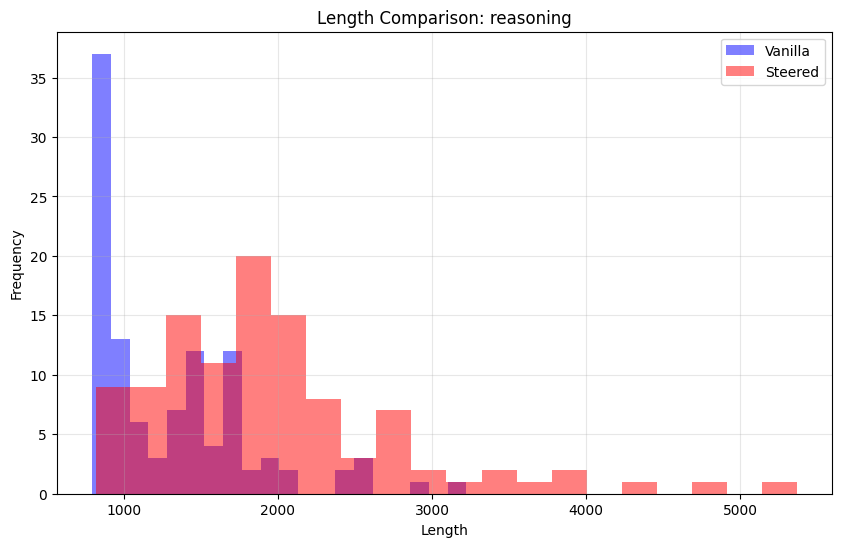

Dataset: reasoning
Vanilla - Mean: 1293.24, Min: 795, Max: 3222, Std: 514.02, StdErr: 49.46
Steered - Mean: 1971.29, Min: 822, Max: 5365, Std: 818.88, StdErr: 78.80
Difference (Steered - Vanilla): 678.05
--------------------------------------------------------------------------------


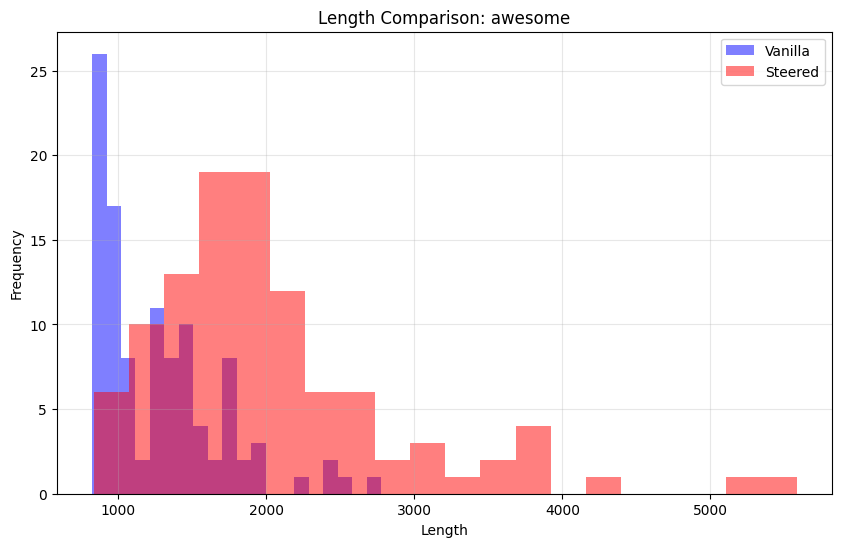

Dataset: awesome
Vanilla - Mean: 1258.02, Min: 822, Max: 2775, Std: 428.69, StdErr: 41.64
Steered - Mean: 2031.47, Min: 835, Max: 5583, Std: 846.49, StdErr: 82.22
Difference (Steered - Vanilla): 773.45
--------------------------------------------------------------------------------


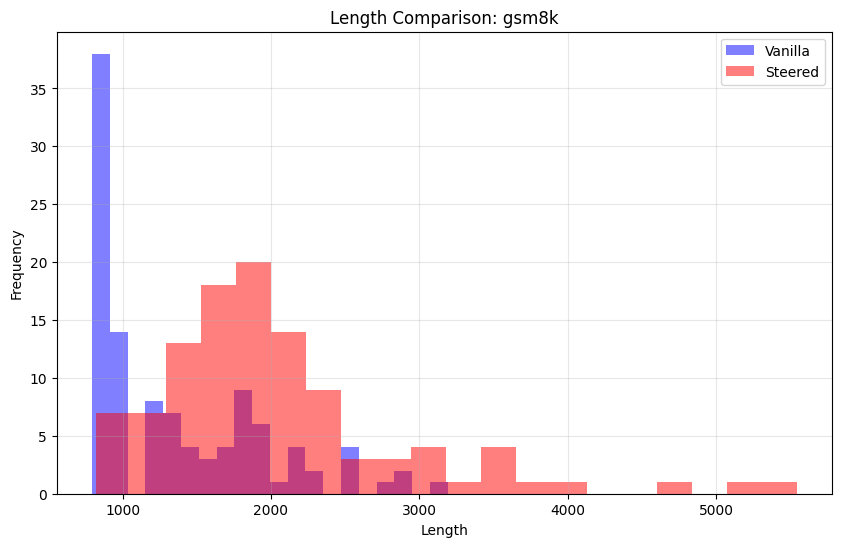

Dataset: gsm8k
Vanilla - Mean: 1360.06, Min: 795, Max: 3191, Std: 588.36, StdErr: 56.61
Steered - Mean: 2030.29, Min: 822, Max: 5543, Std: 844.13, StdErr: 81.23
Difference (Steered - Vanilla): 670.23
--------------------------------------------------------------------------------


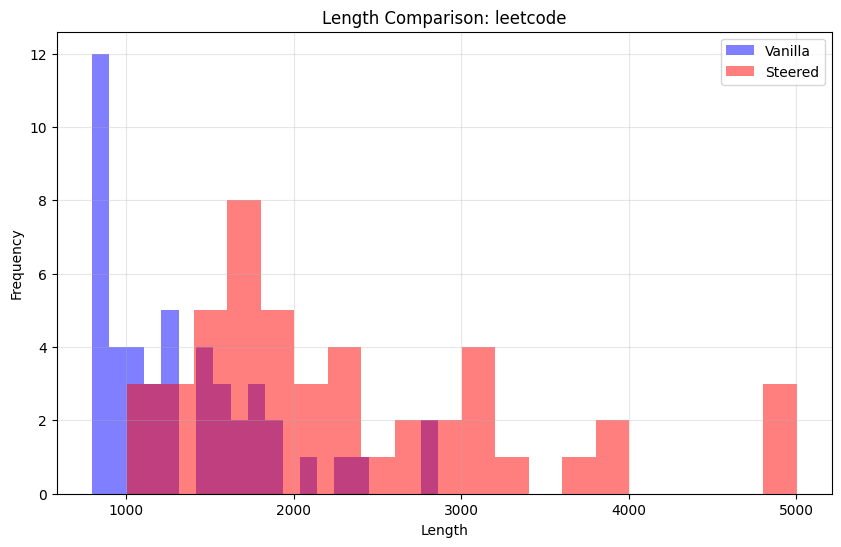

Dataset: leetcode
Vanilla - Mean: 1345.17, Min: 795, Max: 2862, Std: 518.98, StdErr: 75.70
Steered - Mean: 2312.81, Min: 1002, Max: 5002, Std: 991.33, StdErr: 144.60
Difference (Steered - Vanilla): 967.64
--------------------------------------------------------------------------------


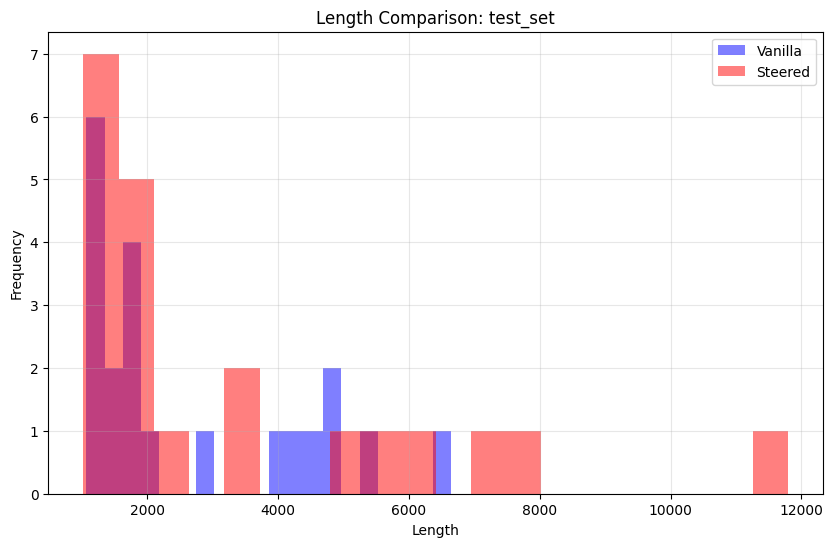

Dataset: test_set
Vanilla - Mean: 2712.33, Min: 1068, Max: 6639, Std: 1718.99, StdErr: 375.11
Steered - Mean: 3397.24, Min: 1022, Max: 11794, Std: 2780.85, StdErr: 606.83
Difference (Steered - Vanilla): 684.90
--------------------------------------------------------------------------------


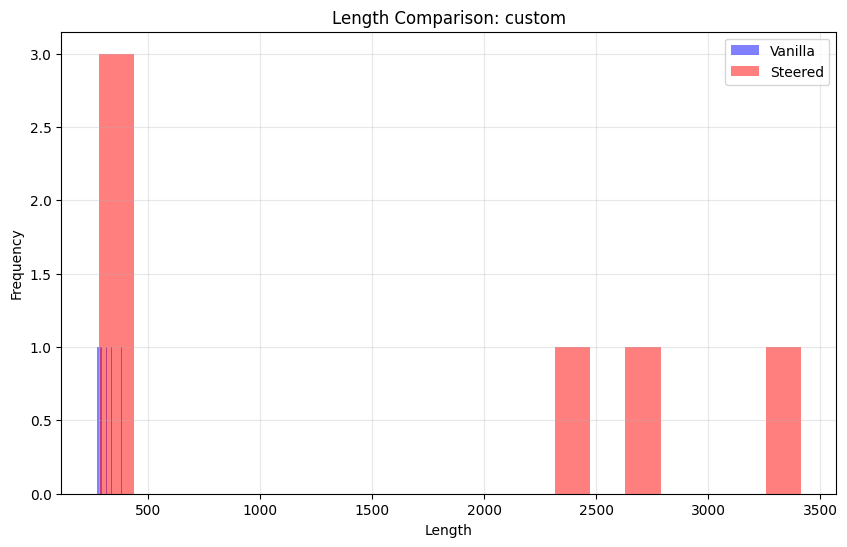

Dataset: custom
Vanilla - Mean: 312.17, Min: 270, Max: 386, Std: 39.82, StdErr: 16.26
Steered - Mean: 1584.83, Min: 280, Max: 3414, Std: 1279.79, StdErr: 522.47
Difference (Steered - Vanilla): 1272.67
--------------------------------------------------------------------------------


In [160]:
"""
8B04545E-B159-4A65-AE77-D474D853FE2E

We simply look at the length statistics of both the generations:
"""
# class Prober:
#     """
#     A class to probe the model for steering. It is also basically a static-like class, but stateful
#     (which helps) since it does a bunch of different probes in sequence/parallel (basically the goal
#     with this is to get a probe of the activations at every single layer of the model so we need to
#     run the same thing like a gazillion times and it helps to abstract this).
#     """
#     def __init__(self, activations_dataset: Dataset, generations_dataset: Dataset) -> None:
#         self.activations_dataset = activations_dataset
#         self.generations_dataset = generations_dataset
#         raise NotImplementedError

#     def probe(self) -> Tuple[float, float]:
#         raise NotImplementedError

lengths_vanilla = {dname: np.array([len(v) for v in dataset_name2all_vanilla_generations[dname].generations]) for dname in dataset_name2all_vanilla_generations}
lengths_steered = {dname: np.array([len(v) for v in dataset_name2all_steered_l15_generations[dname].generations]) for dname in dataset_name2all_steered_l15_generations}
assert set(lengths_vanilla.keys()) == set(lengths_steered.keys())
for dname in lengths_vanilla:
    lengths_vanilla[dname] = np.array(lengths_vanilla[dname])
    vanilla_mean, vanilla_min, vanilla_max, vanilla_std, vanilla_stderr = np.mean(lengths_vanilla[dname]), np.min(lengths_vanilla[dname]), np.max(lengths_vanilla[dname]), np.std(lengths_vanilla[dname]), np.std(lengths_vanilla[dname]) / np.sqrt(len(lengths_vanilla[dname]))
    lengths_steered[dname] = np.array(lengths_steered[dname])
    steered_mean, steered_min, steered_max, steered_std, steered_stderr = np.mean(lengths_steered[dname]), np.min(lengths_steered[dname]), np.max(lengths_steered[dname]), np.std(lengths_steered[dname]), np.std(lengths_steered[dname]) / np.sqrt(len(lengths_steered[dname]))
    # Create a histogram plot for comparing vanilla and steered lengths
    plt.figure(figsize=(10, 6))
    plt.hist(lengths_vanilla[dname], bins=20, alpha=0.5, color='blue', label='Vanilla')
    plt.hist(lengths_steered[dname], bins=20, alpha=0.5, color='red', label='Steered')
    plt.title(f"Length Comparison: {dname}")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Print out the statistics
    print(f"Dataset: {dname}")
    print(f"Vanilla - Mean: {vanilla_mean:.2f}, Min: {vanilla_min}, Max: {vanilla_max}, Std: {vanilla_std:.2f}, StdErr: {vanilla_stderr:.2f}")
    print(f"Steered - Mean: {steered_mean:.2f}, Min: {steered_min}, Max: {steered_max}, Std: {steered_std:.2f}, StdErr: {steered_stderr:.2f}")
    print(f"Difference (Steered - Vanilla): {steered_mean - vanilla_mean:.2f}")
    print("-" * 80)


